In [1]:
from numpy import *
# from matplotlib.pyplot import *
# import os
# ion()

# find hinges
def splitHinge(vals, sites, block):
    # split hinges
    currBlock = 1
    index = 0
    isStart = False
    newSites = []
    newVals = []

    for val in vals:
        if block[index] == currBlock and not isStart:
            isStart = True
            currSites = [sites[index]]
            currValLists = [vals[index]]
        elif block[index] == currBlock and isStart:
            currSites.append(sites[index])
            currValLists.append(vals[index])
        else:
            currBlock += 1
            isStart = True
            newSites.append(currSites)
            newVals.append(currValLists)
            currSites = [sites[index]]
            currValLists = [vals[index]]
        if currBlock == block[-1] and index == len(vals) - 1:
            newSites.append(currSites)
            newVals.append(currValLists)
        index += 1
    # print newSites, newVals
    return newSites, newVals


def mini(a, b):
    if a > b:
        return a
    else:
        return b


def checkIfCrossBase(currVal, currSite, currEigenVec):
    identify = sort(currVal)
    ifRemain = True
    if identify[0] < 0 and identify[-1] > 0:
        ifRemain = True
    else:
        maxSite = max(currSite)
        minSite = min(currSite)
        # print (identify)
        if identify[0] >= 0 and identify[-1] >= 0:
            if currEigenVec[max(0, minSite - 1)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 1)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 2)] < 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] < 0 or currEigenVec[min(len(currEigenVec) - 1, maxSite + 3)] < 0:
                ifRemain = True
            else:
                ifRemain = False
        elif identify[0] <= 0 and identify[-1] <= 0:
            # print (len(currEigenVec))
            # print (currEigenVec[239])

            if currEigenVec[max(0, minSite - 1)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 1))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 2)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 2))] > 0:
                ifRemain = True
            elif currEigenVec[max(0, minSite - 3)] > 0 or currEigenVec[min(len(currEigenVec) - 1, (maxSite + 3))] > 0:
                ifRemain = True
            else:
                ifRemain = False

        else:
            print(identify[0], identify[-1])
            print("Check!")
    return ifRemain


def oneModeHinge(currEigenVec, thereshold=20):
    range = ((1 / float(len(currEigenVec))) ** 0.5) / thereshold
    # print (range)
    # print range
    sites = []
    vals = []
    block = []

    index = 0
    blockID = 1
    for item in currEigenVec:
        if item <= range and item >= -range:
            vals.append(item)
            if len(sites) >= 1 and abs(sites[-1] - index) > 1:
                blockID += 1
            sites.append(index)
            block.append(blockID)
        index += 1

    newSites, newVals = splitHinge(vals, sites, block)

    filtSites = []
    filtVals = []

    index = 0
    for item in newSites:
        currSite = newSites[index]
        currVal = newVals[index]
        if checkIfCrossBase(currVal, currSite, currEigenVec):
            filtSites.append(currSite)
            filtVals.append(currVal)
        index += 1

    return filtSites, filtVals


def getValue(currList):
    newList = []
    for item in currList:
        newList.append(float(item))
    return newList


def readModes(fileName):
    allModes = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.strip()
            line = line.split('\t')
            currMode = line[0]
            currVal = line[1:]
            allModes[currMode] = getValue(currVal)
    return allModes


def flattenData(arrayTwoD):
    flat = []
    for item in arrayTwoD:
        for each in item:
            flat.append(each)
    return flat

def cleanStr(currStr):
    return currStr.strip('\'')

def readFile(fileName):
    data = {}
    with open(fileName, 'r') as rf:
        for line in rf.readlines():
            line = line.replace('\n', '')
            line = line.strip()
            line = line.split('\t')
            currPDB = line[0]
            currDrug = line[1]
            currChain = line[2:]
            if currPDB not in data.keys():
                data[currPDB] = {}
            if currDrug not in data[currPDB].keys():
                data[currPDB][currDrug] = []
            for each in currChain:
                data[currPDB][currDrug].append(cleanStr(each))
    return data

# contribution of mode of motions
def getContribution(eigenVals, mode):
    allContribution = sqrt(sum(1 / eigenVals))
    currModeContribution = eigenVals[:mode]
    currContribution = sqrt(sum(1 / currModeContribution))
    return currContribution / allContribution

def getModesGivenThreshold(eigenVals, thereshold):
    contribution = 0
    mode = 0
    while contribution <= thereshold:
        mode += 1
        contribution = getContribution(eigenVals, mode)
    return mode

def writeBinding(fileName, pdb_ids):
    with open(fileName, 'w') as wf:
        for item in pdb_ids:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')


from prody import *
def getModes(currPDB, eachChain, length = 0.7, rmsd = 1.0, Z = 10):    
    # if not os.path.exists('./Results/' + currPath):
    #     os.mkdir('./Results/' + currPath)
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len = length, cutoff_rmsd = rmsd, cutoff_Z = Z)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    
    ags = parsePDB(pdb_ids, subset='ca')
    dali_ens = buildPDBEnsemble(ags, mapping=mappings, seqid=20)
    gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
    eigVals = gnms.getEigvals()
    averageEigVals = mean(eigVals, axis=0)

    eigVects = gnms.getEigvecs()
    averageEigVects = mean(eigVects, axis=0)
    return averageEigVals, averageEigVects, pdb_ids, gnms, averageEigVects

            
def getDali_info(currPDB, eachChain, rmsd = 2.5, length = 0.9):
    dali_rec = searchDali(currPDB, eachChain)
    while not dali_rec.isSuccess:
        dali_rec.fetch()

    pdb_ids = dali_rec.filter(cutoff_len=length, cutoff_rmsd=rmsd)
    # pdb_ids = dali_rec.filter(cutoff_identity=0.5)

    currNumber = len(pdb_ids) # this number should over 50 as cutoffs

    print ('# of similar structures is found from Dali', currNumber)
    mappings = dali_rec.getMappings()
    return pdb_ids, mappings

def getHinges(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge


def getHinges_modes(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge

def get3Hinges_bandwidth(averageEigVects, bandWidths = [15, 16, 17]):
    currHinge = []
    for i in range(3):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge(averageEigVects[:, i], thereshold=bandWidths[i])
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

In [2]:
def oneModeHinge_update(values, thereshold=20):
    band = (-sqrt(1/len(values))/thereshold, sqrt(1/len(values))/thereshold)
    # print ('Band is', band)
    
    # Identify crossover points
    crossovers = [i for i in range(1, len(values)) if \
                  (values[i-1] < 0 and values[i] > 0) or \
                  (values[i-1] > 0 and values[i] < 0)]
    # print ('crossovers', crossovers)
    
    # Process each crossover to find the start and end of each region
    regions = []
    for i in crossovers:
        # Initialize region
        region = [i-1, i]
        # print (region)
        
        if (region[0] < band[0] and region[1] > band[1]) or \
        (region[0] < band[1] and region[1] > band[0]):
            regions.append(region)

        else:
            # Extend backwards
            j = i - 2
            while j >= 0 and (band[0] <= values[j] <= band[1]):
                region.insert(0, j)
                j -= 1
                # print (values[j])
                
            # Extend forwards
            j = i + 1
            while j < len(values) and (band[0] < values[j] < band[1]):
                region.append(j)
                j += 1
            regions.append(region)
            
        # print (region)
    regions = merge_overlapping_lists(regions)
    # print (regions)
    
    FinalRegions = []
    for region in regions:
        # print ('before filtering', region)
        if len(region) >= 5:
            # print ('previous region', region)
            pos = [index for index in region if values[index] > 0]
            neg = [index for index in region if values[index] < 0]
            pos.sort(key=lambda x: values[x])
            neg.sort(key=lambda x: values[x], reverse=True)
            n = int(len(region) / 4) + 1
            region = pos[:n] + neg[:n]
            # print (region, neg, pos)
        elif 3 <= len(region) <= 4:
            if values[region[0]-1] * values[region[-1]+1] > 0:
                continue  # Skip this region if adjacent values outside the band have the same sign
        # print ('after filtering',region)      
            
        if region not in FinalRegions:
            FinalRegions.append(region)
    
    # print ('Final regions', FinalRegions)
    
    flat = flattenData(FinalRegions)
    # print (len(flat))
    # Extract indices and values for the final list
    final_values = [values[index] for index in flat]
    
    return FinalRegions, final_values

def getHinges2(averageEigVects, currNumModes, bandWidth = 15):
    currHinge = []
    for i in range(currNumModes):
        # print (i, len(averageEigVects[:, i]))
        currPos, currVals = oneModeHinge_update(averageEigVects[:, i], thereshold=bandWidth)
        currPos = flattenData(currPos)
        # print (currPos)
        currHinge += currPos
        currHinge = list(set(currHinge))
    return currHinge

def getHinges_modes2(averageEigVects, mode, bandWidth = 15):
    currHinge = []
    # print (i, len(averageEigVects[:, i]))
    currPos, currVals = oneModeHinge_update(averageEigVects[:, mode], thereshold=bandWidth)
    currPos = flattenData(currPos)
        # print (currPos)
    currHinge += currPos
    currHinge = list(set(currHinge))
    return currHinge



In [3]:
# Experiment to evaluate performance of hypergeometric p values
from scipy.stats import hypergeom
def ORA(M, N, n, k):
    total = 0
    totalLength = N
    binding = M
    hinge = n
    overlap = k
    
    for i in range(overlap):
        total += hypergeom.pmf(i, totalLength, binding, hinge)
    return 1 - total


import os
def writeIDs(path, idList):
    # Check whether the specified path exists or not
    isExist = os.path.exists(path)
    if not isExist:

       # Create a new directory because it does not exist
       os.makedirs(path)
       print("The new directory is created!")
    
    with open(path + '/ids_diverse.txt', 'w') as wf:
        for item in idList:
            wf.write(item[:4] + '\t' + item[-1])
            wf.write('\n')
            
            
def screenIDs(ids):
    newIDs = []
    for item in ids:
        newIDs.append(item[:4])
    return newIDs

In [4]:
def writeNumbers(path, numbers):
    with open(path, 'w') as wf:
        for item in numbers:
            wf.write(str(item) + '\n')

def merge_overlapping_lists(lists):
    sorted_lists = sorted(lists, key=lambda x: x[0])  # Sort lists based on the first element
    merged_lists = [sorted_lists[0]]
    
    for current in sorted_lists[1:]:
        previous = merged_lists[-1]
        # Check if the current list overlaps with the previous one
        if current[0] <= previous[-1]:
            # Merge overlapping lists by updating the last list in merged_lists
            merged_lists[-1] = list(range(min(previous[0], current[0]), max(previous[-1], current[-1])+1))
        else:
            merged_lists.append(current)
    return merged_lists

In [100]:
# remove first and last hinges for each chain
def filterTwoEnds(hinges, chainLength = [[0, 551], [552, 956]], trimmingLength = 15):
    FilteringIndex = []
    for item in chainLength:
        # print (item)
        FilteringIndex += list(range(item[0], item[0] + trimmingLength))
        FilteringIndex += list(range(item[1] - trimmingLength + 1, item[1] + 1))  
    updateHinges = []
    for item in hinges:
        if item not in FilteringIndex:
            updateHinges.append(item)
    
    return updateHinges

# diverse ensemble

In [15]:
currPDB = '6f2l'
eachChain = 'A'

# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_A, averageEigVects_A, ids_A, gnms_A, averageEigVects_A = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Retrieving 6f2lA... [  0%] results...

# of similar structures is found from Dali 406


@> Mapping 5u3qB_ca to the reference... [ 50%] 5s@> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 2qmvA_ca to the reference... [ 99%] 1s@> WARNING 1 structures cannot be mapped.
@> Calculating all GNM modes for 405 conformations... [ 99%] 1s @> WARNING last 13 modes for 245 modes from MaskedGNM 6f2lA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 6o68A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 6d3eA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 8dszA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 11 modes for 245 modes from MaskedGNM 5y2oA_ca reduced has been discarded because at least one conformation has only 245 modes
@> W

@> WARNING last 12 modes for 245 modes from MaskedGNM 4f9mA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 2prgA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 7 modes for 245 modes from MaskedGNM 3s9sA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 3v9yA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 3b1mA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 6t1vA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1zgyA_ca reduced has been discarded because at least one conformation has only 245 modes
@

@> WARNING last 12 modes for 245 modes from MaskedGNM 3et2A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6md0B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1prgB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 3cs8A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 4r6sB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6md2B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 6augB_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 11 modes for 245 modes from MaskedGNM 5u3yA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 7vwfB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 3adsB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 7bq0C_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 8hukA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 3vspB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 5xmxA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 6 modes for 245 modes from MaskedGNM 2vv2B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 8hukC_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 8 modes for 245 modes from MaskedGNM 5y2tB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 3gwxB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1gwxB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 8huoA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 7 modes for 245 modes from MaskedGNM 8hunA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 2 modes for 245 modes from MaskedGNM 3dy6B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 3 modes for 245 modes from MaskedGNM 6kxyA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 4 modes for 245 modes from MaskedGNM 7wglA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 6kypA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 6l37B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 11 modes for 245 modes from MaskedGNM 6l36B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 5u3xA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 12 modes for 245 modes from MaskedGNM 8b8xA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 8 modes for 245 modes from MaskedGNM 3ty0B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6l96B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 2xywA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 5u3zB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6kxxA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 3 modes for 245 modes from MaskedGNM 2bawA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WA

In [16]:
currPDB = '6f2l'
eachChain = 'A'
# pdb_ids, mappings = getDali_info(currPDB, eachChain, cutoff_len=0.7, cutoff_rmsd=1.0, cutoff_Z=10)
averageEigVals_B, averageEigVects_B, ids_B, gnms_B, averageEigVects_B = getModes(currPDB, eachChain, length=0.95, rmsd=1, Z=10)


@> Retrieving 6f2lA... [  0%] results...

# of similar structures is found from Dali 406


@> Mapping 5u3qB_ca to the reference... [ 50%] 5s @> WARNING no atommaps were available. Consider adjusting accepting criteria
@> Mapping 2qmvA_ca to the reference... [ 99%] 1s@> WARNING 1 structures cannot be mapped.
@> Calculating all GNM modes for 405 conformations... [ 99%] 1s @> WARNING last 13 modes for 245 modes from MaskedGNM 6f2lA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 6o68A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 6d3eA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 8dszA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 11 modes for 245 modes from MaskedGNM 5y2oA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 12 modes for 245 modes from MaskedGNM 4f9mA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 2prgA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 7 modes for 245 modes from MaskedGNM 3s9sA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 3v9yA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 3b1mA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 6t1vA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1zgyA_ca reduced has been discarded because at least one conformation has only 245 modes
@

@> WARNING last 12 modes for 245 modes from MaskedGNM 3et2A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6md0B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1prgB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 3cs8A_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 4r6sB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6md2B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 6augB_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 11 modes for 245 modes from MaskedGNM 5u3yA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 7vwfB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 3adsB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 7bq0C_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 8hukA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 3vspB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 5xmxA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 6 modes for 245 modes from MaskedGNM 2vv2B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 8hukC_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 8 modes for 245 modes from MaskedGNM 5y2tB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 3gwxB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 13 modes for 245 modes from MaskedGNM 1gwxB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 8huoA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 7 modes for 245 modes from MaskedGNM 8hunA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 2 modes for 245 modes from MaskedGNM 3dy6B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 3 modes for 245 modes from MaskedGNM 6kxyA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 4 modes for 245 modes from MaskedGNM 7wglA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 12 modes for 245 modes from MaskedGNM 6kypA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 10 modes for 245 modes from MaskedGNM 6l37B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 11 modes for 245 modes from MaskedGNM 6l36B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 9 modes for 245 modes from MaskedGNM 5u3xA_ca reduced has been discarded because at least one conformation has only 245 modes
@> 

@> WARNING last 12 modes for 245 modes from MaskedGNM 8b8xA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 8 modes for 245 modes from MaskedGNM 3ty0B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6l96B_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 2xywA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 5 modes for 245 modes from MaskedGNM 5u3zB_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 6 modes for 245 modes from MaskedGNM 6kxxA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WARNING last 3 modes for 245 modes from MaskedGNM 2bawA_ca reduced has been discarded because at least one conformation has only 245 modes
@> WA

In [24]:
mergeIDs = []
mergeChains = []
usedStruct = []

for item_A in ids_A:
    for item_B in ids_B:
        if item_A[:4] == item_B[:4] and item_A[-1] != item_B[-1]:
            if item_A[:4] not in usedStruct:
                usedStruct.append(item_A[:4])
                mergeIDs.append(item_A[:4])
                mergeChains.append(item_A[-1] + item_B[-1])

mergeIDs = list(set(mergeIDs))

In [25]:
len(mergeIDs)

88

In [26]:
len(mergeChains)

88

In [50]:
update_mergeIDs = []
update_mergeChains = []
for i in range(len(mergeIDs)):
    if mergeIDs[i] not in ['8huk', '6k0t', '6fzj', '7bpz', '2npa', '7bq0', '1k7l', '7bpy', '6ijr', '1fm6', '5azt']:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append(mergeChains[i])
    elif mergeIDs[i] in ['6fzj', '5azt']:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append('AB')
    elif mergeIDs[i] in ['1fm6']:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append('AD')
    
    else:
        update_mergeIDs.append(mergeIDs[i])
        update_mergeChains.append('AC')

In [104]:
ags = parsePDB(update_mergeIDs, subset='ca', chain='A B')

try:
    dali_ens = buildPDBEnsemble(ags)
except StopIteration:
    pass
    
gnms = calcEnsembleENMs(dali_ens, model='GNM', trim='reduce', n_modes=None)
eigVals = gnms.getEigvals()
averageEigVals = gnms.getEigvals()[0]
eigVects = gnms.getEigvecs()
averageEigVecs = mean(eigVects, axis=0)

@> Solving for 3-best solution...rence... [  1%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  2%]@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  3%] 17s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  4%] 18s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  5%] 19s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  6%] 21s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  7%] 21s@> WARNING no atommaps were found. Consider inceasing rmsd_reject or drmsd
@> Solving for 3-best solution...rence... [  9%] 22s@> WARNING no atommaps were found. Consider inceasing rmsd_reject o

In [110]:
bindings = ['23', '25', '27', '28', '29', '30', '32', '47', '48', '49', '50', '83', '84', '86', '124', '126', '128', '129', '130', '131', '133', '149', '150', '151', '152', '183', '184', '185', '187']


binding = [int(x) for x in bindings]


In [111]:
averageEigVals_2 = mean(eigVals, axis=0)
currNumModes = getModesGivenThreshold(averageEigVals_2, 0.33)
currNumModes

6

In [112]:
currNumModes = getModesGivenThreshold(averageEigVals, 0.33)
currNumModes

3

In [113]:
len(binding)

29

In [114]:
averageEigVects = averageEigVecs

In [115]:
Hinges_2 = getHinges(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges(averageEigVects, 3, 20)

Hinges_4 = getHinges(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges(averageEigVects, 3, 15)


In [116]:
print (len(Hinges_4))

289


In [131]:
protein_length = 514

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 30
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 178 11 0.47532816291804303
# of hinge sites for first 3 modes, overlap, hyper score 178 11 0.47532816291804303
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 198 12 0.5033832743838982
# of hinge sites for first 3 modes, overlap, hyper score 198 12 0.5033832743838982


In [132]:
hivPR = parsePDB('6f2l')
calphas = hivPR.select('calpha and chain A B')
gnm = GNM('hivPR')
gnm.buildKirchhoff(calphas)
gnm.calcModes(n_modes=None)
eigenVals = gnm.getEigvals()
eigenVects = gnm.getEigvecs()
Hinge0 = calcHinges(gnm[0])
Hinge1 = calcHinges(gnm[1])
Hinge2 = calcHinges(gnm[2])

In [133]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 30
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 206 15 0.17058494200953367
# of hinge sites for 3 modes, overlap, hyper score 206 15 0.17058494200953367
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 223 15 0.28512768794220866
# of hinge sites for 3 modes, overlap, hyper score 223 15 0.28512768794220866


## writeResults

In [35]:
averageEigVects.shape

(209, 183)

In [403]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)
len(MSF)

630

In [404]:
values_array = np.array(sqrt(MSF))

# Get indices of the 5 smallest values
indices = np.argsort(values_array)

if not os.path.exists('./Data'):
    os.mkdir('./Data')

writeNumbers('./Data/RMSF_minimum.txt', indices)

In [405]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [406]:
modes = [0, 1, 2]
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge)))) # + list(calcHinges(gnm[mode])))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [407]:
curr = list(curr)
def writeAllData(path, curr):
    with open(path, 'w') as wf:
        for row in curr:
            for col in row:
                if col == 0.0:
                    wf.write('' + '\t')
                else:
                    wf.write(str(col) + '\t')
            wf.write('\n')
                
writeAllData('./Data/ALB_Method1.txt', curr)

## Method 2

In [118]:
bindings = ['59', '65', '66', '68', '69', '72', '76', '110', '111', '114', '117', '123', '125', '126', '148', '320', '326', '327', '329', '330', '333', '337', '371', '372', '375', '378', '384', '386', '387', '409']

binding = [int(x) for x in bindings]

In [119]:
Hinges_2 = getHinges2(averageEigVects, currNumModes, 20)
Hinges_3 = getHinges2(averageEigVects, 3, 20)

Hinges_4 = getHinges2(averageEigVects, currNumModes, 15)
Hinges_5 = getHinges2(averageEigVects, 3, 15)

In [120]:
Hinges_2 = filterTwoEnds(Hinges_2, [[0, 258], [259, 513]], 15)
Hinges_3 = filterTwoEnds(Hinges_3, [[0, 258], [259, 513]], 15)
Hinges_4 = filterTwoEnds(Hinges_4, [[0, 258], [259, 513]], 15)
Hinges_5 = filterTwoEnds(Hinges_5, [[0, 258], [259, 513]], 15)

In [121]:
protein_length = 514

overlaps_2 = len(binding) + len(Hinges_2) - len(set(binding + Hinges_2))
overlaps_3 = len(binding) + len(Hinges_3) - len(set(binding + Hinges_3))
overlaps_4 = len(binding) + len(Hinges_4) - len(set(binding + Hinges_4))
overlaps_5 = len(binding) + len(Hinges_5) - len(set(binding + Hinges_5))

HyperScore_2 = ORA(len(binding), protein_length, len(Hinges_2), overlaps_2)
HyperScore_3 = ORA(len(binding), protein_length, len(Hinges_3), overlaps_3)
HyperScore_4 = ORA(len(binding), protein_length, len(Hinges_4), overlaps_4)
HyperScore_5 = ORA(len(binding), protein_length, len(Hinges_5), overlaps_5)

print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_2), overlaps_2, HyperScore_2)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_3), overlaps_3, HyperScore_3)

print ('Hinge allocated zeta = 15')
print ('# of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_4), overlaps_4, HyperScore_4)
print ('# of hinge sites for first 3 modes, overlap, hyper score', len(Hinges_5), overlaps_5, HyperScore_5)


# of binding sites is 30
Hinge allocated zeta = 20
# of hinge sites for threshold 0.35, overlap, hyper score 178 11 0.47532816291804303
# of hinge sites for first 3 modes, overlap, hyper score 178 11 0.47532816291804303
Hinge allocated zeta = 15
# of hinge sites for threshold 0.35, overlap, hyper score 198 12 0.5033832743838982
# of hinge sites for first 3 modes, overlap, hyper score 198 12 0.5033832743838982


In [122]:
Hinges_sep2 = list(set(Hinges_2 + Hinge0))
Hinges_sep3 = list(set(Hinges_3 + Hinge0 + Hinge1 + Hinge2))
Hinges_sep4 = list(set(Hinges_4 + Hinge0))
Hinges_sep5 = list(set(Hinges_5 + Hinge0 + Hinge1 + Hinge2))

overlaps_sep2 = len(binding) + len(Hinges_sep2) - len(set(binding + Hinges_sep2))
overlaps_sep3 = len(binding) + len(Hinges_sep3) - len(set(binding + Hinges_sep3))
overlaps_sep4 = len(binding) + len(Hinges_sep4) - len(set(binding + Hinges_sep4))
overlaps_sep5 = len(binding) + len(Hinges_sep5) - len(set(binding + Hinges_sep5))


HyperScore_sep2 = ORA(len(binding), protein_length, len(Hinges_sep2), overlaps_sep2)
HyperScore_sep3 = ORA(len(binding), protein_length, len(Hinges_sep3), overlaps_sep3)
HyperScore_sep4 = ORA(len(binding), protein_length, len(Hinges_sep4), overlaps_sep4)
HyperScore_sep5 = ORA(len(binding), protein_length, len(Hinges_sep5), overlaps_sep5)


print ('# of binding sites is', len(binding))
print ('Hinge allocated zeta = 20')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep2), overlaps_sep2, HyperScore_sep2)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep3), overlaps_sep3, HyperScore_sep3)

print ('Hinge allocated zeta = 15')
print ('# of of hinge sites for threshold 0.35, overlap, hyper score', len(Hinges_sep4), overlaps_sep4, HyperScore_sep4)  
print ('# of hinge sites for 3 modes, overlap, hyper score', len(Hinges_sep5), overlaps_sep5, HyperScore_sep5)

# of binding sites is 30
Hinge allocated zeta = 20
# of of hinge sites for threshold 0.35, overlap, hyper score 184 11 0.5307275239725339
# of hinge sites for 3 modes, overlap, hyper score 206 15 0.17058494200953367
Hinge allocated zeta = 15
# of of hinge sites for threshold 0.35, overlap, hyper score 203 12 0.5484656734584346
# of hinge sites for 3 modes, overlap, hyper score 223 15 0.28512768794220866


## writeResults

In [412]:
# write MSFs
averageEigVals
modes = [0, 1, 2]
MSF = []

row, col = averageEigVects.shape
for i in range(row):
    currMSF = 0
    for mode in modes:
        currMSF += averageEigVects[i, mode] ** 2 / averageEigVals[mode]
    MSF.append(currMSF)

In [413]:
includeModes = 3
size = includeModes * 2 + 1 + 2 

curr = zeros((len(MSF), size))
# write MSF and RMSF
curr[:, -1] = sqrt(MSF)
curr[:, -2] = MSF

# write modes
curr[:, 1] = averageEigVects[:, 0]
curr[:, 3] = averageEigVects[:, 1]
curr[:, 5] = averageEigVects[:, 2]

for each in binding:
    curr[each, 0] = each

In [414]:
row, col = averageEigVects.shape

for mode in modes:
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currList = sort(list(set(list(currHinge))))
    for item in currList:
        curr[item, mode*2 + 2] = curr[item, mode*2 + 1]

In [415]:
writeAllData('./Data/ALB_Method2.txt', curr)

# Write Modes

In [36]:
def writeModesAsBfactors(mode, eigenVects):
    residue = []
    new_b_factor = []
    chain = 'A'

    resiIndex = 4
    for item in eigenVects[:, mode]:
        resiIndex += 1
        residue.append(resiIndex)
        new_b_factor.append(item)

    with open('./Structure_demo/ALB_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
        for i in range(len(residue)):
            wf.write(chain + ', ' + str(residue[i]) + ', ' + str(new_b_factor[i]) + '\n')

In [37]:
writeModesAsBfactors(0, eigenVects)
writeModesAsBfactors(1, eigenVects)

# Plot graphs

In [91]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import numpy as np

def format_significant(value, pos):
    if abs(value) <= 0.01:
        return "0.00"
    else:
        order_of_magnitude = math.floor(math.log10(abs(value)))
        round_digits = -order_of_magnitude + 1
        formatted_number = round(value, round_digits)
        str_format = "{:." + str(round_digits) + "f}"
        return str_format.format(formatted_number)


In [127]:
def plotSingleGraph(mode, averageEigVects, gnms, binding, Hinge):
    fig, ax = plt.subplots(figsize=(15, 10))   # Adjust size as per requirement
    
    plt.sca(ax)  # Set current axis to 'ax'
    
    # Increase font sizes
    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=50)
    plt.rcParams.update({'font.size': 50})

    # plot mode of motion
    showSignatureMode(gnms[:, mode], linewidth=3)

    # Hinges within band
    # method1
    # currHinge = getHinges_modes(averageEigVects, mode, bandWidth=20)
    # method2
    currHinge = getHinges_modes2(averageEigVects, mode, bandWidth=15)
    currHinge = filterTwoEnds(currHinge, [[0, 258], [259, 513]], 15)
    
    HingeY = [averageEigVects[item, mode] for item in currHinge]
    print ('Hinge residue with wide bands', currHinge, len(currHinge))
    plt.plot(currHinge, HingeY, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # extraHinges for local loops
    updateHinge = [item for item in Hinge if item not in currHinge]
    HingeY_local = [averageEigVects[item, mode] for item in updateHinge]
    print ('local loop motion', updateHinge)
    plt.plot(updateHinge, HingeY_local, color=(0.5, 1, 0), marker='o', linestyle='', markersize=15)

    # plot binding sites
    bindingY = [averageEigVects[item, mode] for item in binding]
    plt.plot(binding, bindingY, 'r*', markersize=18)
    print ('current bindings are', binding)
    plt.title('Mode ' + str(mode + 1), fontweight="bold")

    # plot overlaps
    allHinge = updateHinge + currHinge
    overlaps = [item for item in binding if item in allHinge]
    overlapsY = [averageEigVects[item, mode] for item in overlaps]
    print ('current hits are', overlaps)
    plt.plot(overlaps, overlapsY, 'mD', markersize=18)

    print('# of overlaps finding from current mode is', len(overlaps))
    
    # Set y-ticks to have 4-5 values with equal spacing
    y_min, y_max = ax.get_ylim()
    ax.set_yticks(np.linspace(y_min * 0.9, y_max, 5))  # Adjust the number 5 if you want a different number of y-ticks
    ax.yaxis.set_major_formatter(FuncFormatter(format_significant)) 
    
    plt.tight_layout()
    plt.savefig('./try_method2_mode' + str(mode + 1) + '.png', dpi=500)

Hinge residue with wide bands [518, 519, 523, 524, 24, 25, 26, 27, 28, 32, 55, 56, 57, 58, 64, 67, 68, 69, 70, 72, 79, 80, 81, 82, 122, 123, 124, 125, 126, 127, 140, 141, 142, 143, 159, 160, 161, 162, 163, 165, 166, 170, 205, 206, 208, 209, 225, 226, 227, 228, 229, 231, 232, 238, 241, 242, 296, 297, 298, 299, 324, 325, 343, 344, 345, 346, 350, 351, 378, 379, 380, 381, 400, 401, 409, 411, 412, 413, 477, 478, 498] 81
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are [68, 69, 72, 123, 125, 126, 378, 409]
# of overlaps finding from current mode is 8


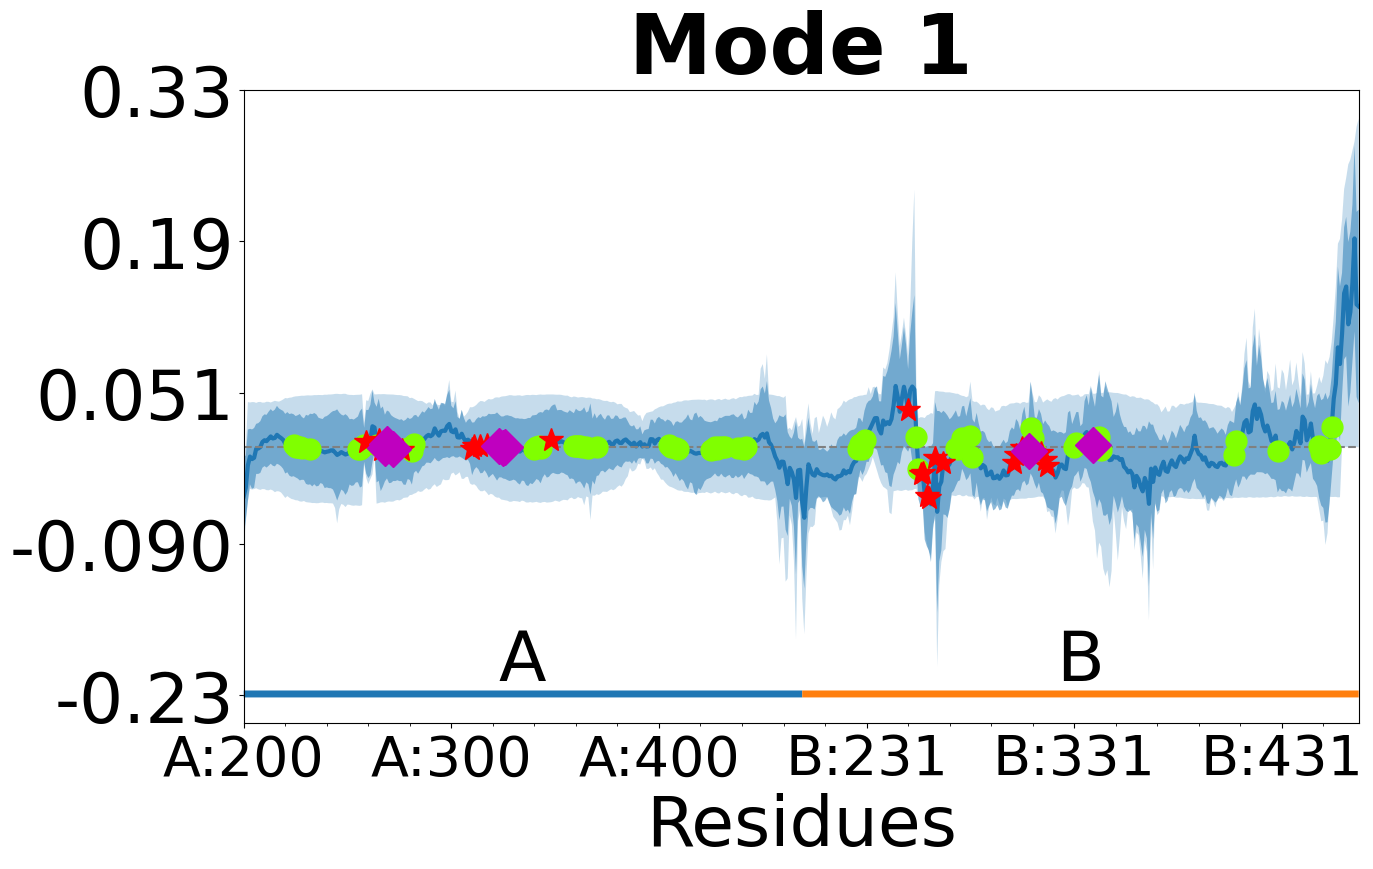

In [128]:
modes = 0 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [22, 23, 488, 489, 160, 161, 162, 163, 291, 289, 294, 295, 491, 298, 493, 306, 307, 308, 309, 438, 439, 440, 441, 437, 435, 494, 447, 448, 449, 450, 451, 452, 453, 454, 497, 81, 82, 467, 468, 469, 470, 471, 466, 465, 474, 355, 356, 357, 358, 360, 361, 490, 363, 364, 365, 238, 239, 367, 366, 368, 369, 371, 492, 374, 496, 495, 121, 122, 123, 124] 70
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are [123, 371]
# of overlaps finding from current mode is 2


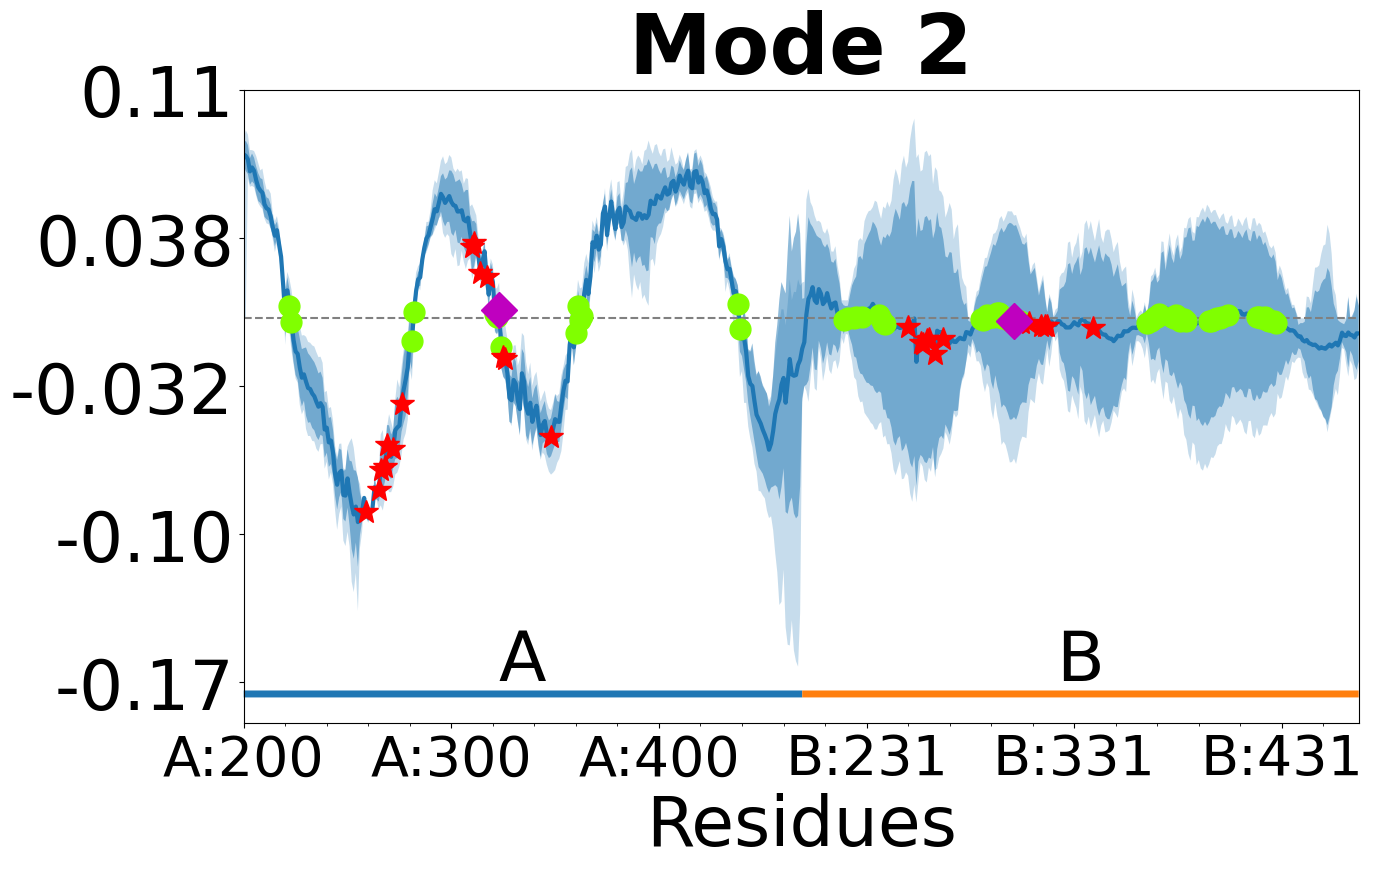

In [129]:
modes = 1 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

Hinge residue with wide bands [527, 528, 36, 37, 38, 39, 40, 41, 42, 43, 44, 50, 52, 57, 59, 61, 62, 79, 80, 81, 82, 83, 84, 96, 100, 102, 105, 106, 107, 108, 109, 110, 111, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 152, 153, 154, 183, 184, 185, 199, 200, 201, 202, 237, 238, 239, 240, 241, 242, 243, 288, 289, 290, 291, 350, 351, 389, 390, 432, 433] 75
local loop motion []
current bindings are [59, 65, 66, 68, 69, 72, 76, 110, 111, 114, 117, 123, 125, 126, 148, 320, 326, 327, 329, 330, 333, 337, 371, 372, 375, 378, 384, 386, 387, 409]
current hits are [59, 110, 111]
# of overlaps finding from current mode is 3


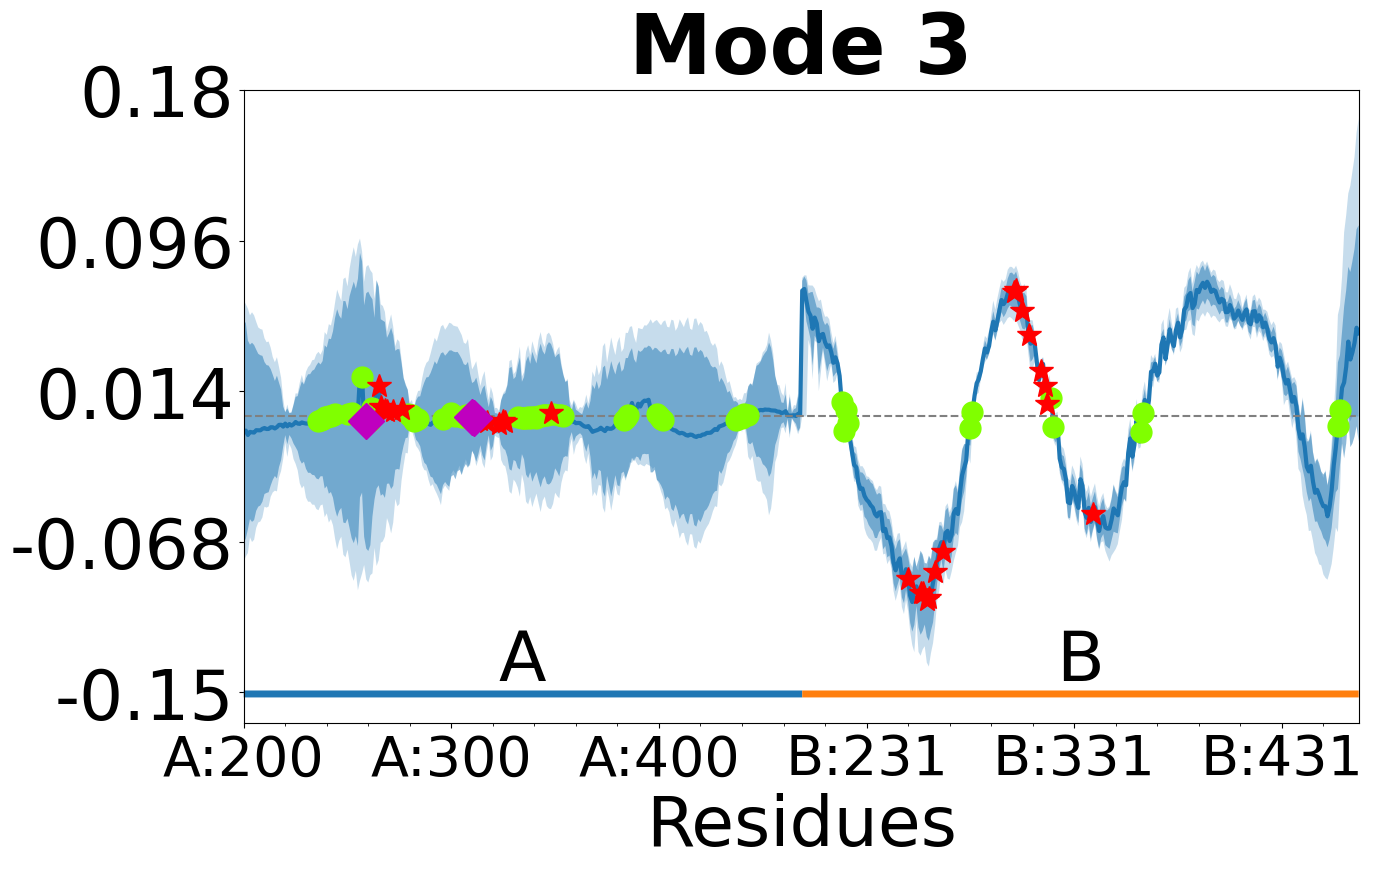

In [130]:
modes = 2 # Example modes
plotSingleGraph(modes, averageEigVects, gnms, binding, [])

# store data

In [259]:
mode = 5

In [260]:
residue = []
new_b_factor = []

for item in eigenVects[:, mode]:
    new_b_factor.append(item)


In [261]:
resiIndex = [x for x in range(537, 666)]
chain = ['A' for x in range(537, 666)]
resiIndex += [x for x in range(676, 860)]
chain += ['A' for x in range(676, 860)]

resiIndex += [x for x in range(537, 665)]
chain += ['B' for x in range(537, 666)]
resiIndex += [x for x in range(676, 860)]
chain += ['B' for x in range(676, 860)]

In [262]:
with open('./structure_demo/PDE5A_b_mode' + str(mode + 1) + '.txt', 'w') as wf:
    for i in range(len(resiIndex)):
        # print (chain[i])
        wf.write(chain[i] + ', ' + str(resiIndex[i]) + ', ' + str(new_b_factor[i]) + '\n')